In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation

# Set up simulation params. 
"""Time step size and total time is primary source of runtime for rendering animation"""
dt = 1e-6 # time step size, seconds
t0 = 0.0
tf = 6e-3 # total time evolution, seconds
t_eval = np.arange(t0, tf, dt)


# Wire properties
""" 
Wire property source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
l = 2 # length of wire, meters
dz = 100e-6 # wire step size, meters
rho = 7850 # mass density, kg/m^3
tensile_str = 2751e6 # Tensile Strength of wire, Pa
young_mod = 207e9 # elastic modulus of wire, Pa
dia = 4e-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2
mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

#Particle Properties
relativistic = [3e8, 1.782e-24] # c [m/s], 1 TeV/c^2 [kg]
thermal_neut = [1919.62, 1.674e-27] # [m/s], [kg] --> T = 298 K, mv^2 = (3/2) k_b T
gal_orbit = [220e3, 1.782e-24] # [m/s], 1 TeV/c^2 [kg]
parts = [relativistic, thermal_neut, gal_orbit]
titles = ["Custom", "Relativistic DM", "Thermal Neutron", "Galactic Orbit DM"]
G = 6.67430e-11 # gravitational constant
M = np.array([p[1] for p in parts]) # mass of inciting particle, meters/second
v_p = np.array([p[0] for p in parts]) # velocity of inciting particle, meters / second

#Impact Properties
z0 = l / 4 # position of particle track and wire 'intersection', meters
bs = np.array([0.01, .05, 0.1]) # shortest distance between wire and particle track, meters
theta = 45 * (np.pi / 180) # Angle between particle track and z (wire) axes, radians
phi = 90 * (np.pi / 180) # Angle between particle track and x axes, radians

zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0
costheta = np.cos(theta)
sintheta = np.sin(theta)
cosphi = np.cos(phi)
sinphi = np.sin(phi)
small = G * (M / v_p)

In [14]:
def theory (t_eval, z_t, b):
    small = G * M / v_p
    def denom(v, direction):
        return (b**2 + (z_t + direction * v * t_eval)**2 * sintheta**2)

    xnum1 = costheta * sintheta * sinphi
    def xnum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * cosphi + (z_t + direction * v_shear * t_eval) * costheta * sintheta * sinphi))
    ax_left = v_shear * (xnum1 / denom(v_shear, 1) - xnum2(1) / denom(v_shear, 1)**2) # left moving wave
    ax_right = v_shear * (- xnum1 / denom(v_shear, -1) + xnum2(-1) / denom(v_shear, -1)**2) # right moving wave
    ax_theory = ax_right + ax_left

    ynum1 = costheta * sintheta * cosphi
    def ynum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * sinphi - (z_t + direction * v_shear * t_eval) * costheta * sintheta * cosphi))
    ay_left = v_shear * (- ynum1 / denom(v_shear, 1) - ynum2(1) / denom(v_shear, 1)**2)
    ay_right = v_shear * (ynum1 / denom(v_shear, -1) + ynum2(-1) / denom(v_shear, -1)**2)
    ay_theory = ay_right + ay_left

    znum1 = sintheta**2
    def znum2(v, direction):
        return (-2 * (z_t + direction * v * t_eval)**2 * sintheta**4)
    az_left = v_press * (-znum1 / denom(v_press, 1) - znum2(v_press, 1) / denom(v_press, 1)**2)
    az_right = v_press * (znum1 / denom(v_press, -1) + znum2(v_press, -1) / denom(v_press, -1)**2)
    az_theory = az_right + az_left    

    return ax_theory, ay_theory, az_theory

In [15]:
# Define needed functions
arr_dim = zwire.size
z_t = arr_dim * 3//8
t_range = range(len(t_eval))


C:\Users\Thomas\AppData\Local\Temp\ipykernel_21428\3867090369.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ax1.plot(t_eval, x_theory[i] / x_theory[i].max(), label=f'b = {bs[i]}', alpha=0.7)


ValueError: x and y must have same first dimension, but have shapes (6000,) and (1,)

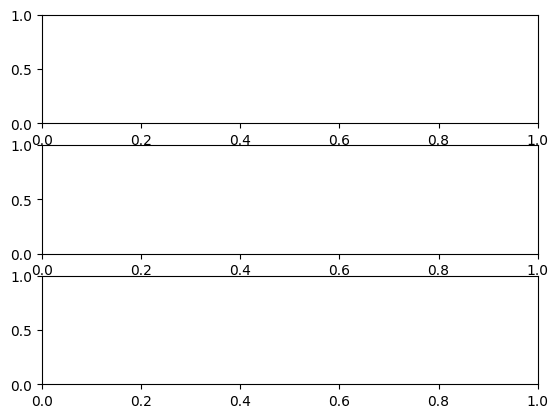

In [16]:
fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_xlabel('Time [s]')

z_t_max = 2e-4
for i in range(3):
    x_theory, y_theory, z_theory = theory(t_eval, zwire[z_t], bs[i])
    # Plot accerlations
    ax1.plot(t_eval, x_theory / x_theory.max(), label=f'b = {bs[i]}', alpha=0.7)
    ax2.plot(t_eval, y_theory / y_theory.max(), label=f'b = {bs[i]}', alpha=0.7)
    ax3.plot(t_eval[t_eval < z_t_max], z_theory[t_eval < z_t_max] / z_theory[t_eval < z_t_max].max(), label=f'b = {bs[i]}', alpha=0.7)
    # Graph aesthetics
    # ax1.set_ylim(-1, 1)
    ax1.set_xlim(t0, tf)
    ax1.set_title('x acceleration')
    ax1.set_ylabel('x_acc / x_acc.max()')

    # ax2.set_ylim(-1, 1)
    ax2.set_xlim(t0, tf)
    ax2.set_title('y acceleration')
    ax2.set_ylabel('y_acc / y_acc.max()')

    # ax3.set_ylim(-z_max, z_max)
    ax3.set_xlim(t0, z_t_max)
    ax3.set_title('z acceleration')
    ax3.set_ylabel('z_acc / z_acc.max()')

fig1.suptitle(f'Accelerations on wire at {zwire[z_t]:.1e} from z_0 over {tf:.1e} seconds')
fig1.tight_layout()
fig1.set_figwidth(10)
fig1.set_figheight(8)